# Visualization with *yt* and Napari Part 1: fixed resolution regions

In this notebook series, we'll explore some ways to use [napari](https://napari.org/) to visualize data loaded and sampled with [*yt*](yt-project.org/).

The inspiration for this series came from watching 'Interactive Image Processing at Scale' from the folks at Coiled and guests Nicholas Sofroniew and Talley Lambert, who presented their work on using napari and dask to load and process multi-resolution images of cells (check out the video [here](https://youtu.be/KG_ye5qzFmk)). In it, Sofroniew and Lambert present some surprisingly simply notebooks that leverage dask's lazy loading and block mapping to define loading and processing functions that get triggered on demand by napari as the user needs it. 

In this frist notebook, we'll keep things fairly simple and first focus on in-memory visualization in which we use *yt* to generate a 3D image that is then visualized with napari. We'll then look at an example using dask to lazily load *yt* slices.

##  general approach

Ultimately, loading data into napari is as simple as:

```
viewer = napari.view_image(image_stack)
```

where `image_stack` is an array object. We'll start with the simplest case in which `image_stack` is an in-memory image array generated by storing images created from *yt* slices and then demonstrate a lazy loading approach with dask. 


## required packages

Running this notebook requires *yt*, napari and dask in addition to stanard packages from the scipy stack (numpy, matplotlib). 


## imports 

So let's start off by setting up the `qt` environment needed by napari:

In [1]:
 # for napari, do it first!
%gui qt

and import all the packages we'll use

In [2]:
# general imports
import numpy as np
import matplotlib.pyplot as plt 
import os

# yt related
import yt
from yt.units import kpc

# napari related imports 
import napari
from napari.utils import nbscreenshot
import logging

# dask imports 
from dask import delayed
import dask.array as da

## Test data 

We'll use a standard *yt* test ENZO dataset, `IsolatedGalaxy`, (download [here](http://yt-project.org/data/IsolatedGalaxy.tar.gz)).

So let's just load up the data and slice at a fixed `z` value as usual in *yt*: 

In [3]:
ds = yt.load("IsolatedGalaxy/galaxy0030/galaxy0030") 

yt : [INFO     ] 2020-09-03 17:32:10,484 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2020-09-03 17:32:10,484 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-09-03 17:32:10,485 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-09-03 17:32:10,485 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-09-03 17:32:10,486 Parameters: cosmological_simulation   = 0.0


Parsing Hierarchy : 100%|██████████| 173/173 [00:00<00:00, 3221.66it/s]
yt : [INFO     ] 2020-09-03 17:32:10,595 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2020-09-03 17:32:11,703 xlim = 0.490001 0.509999
yt : [INFO     ] 2020-09-03 17:32:11,703 ylim = 0.490001 0.509999
yt : [INFO     ] 2020-09-03 17:32:11,704 xlim = 0.490001 0.509999
yt : [INFO     ] 2020-09-03 17:32:11,704 ylim = 0.490001 0.509999
yt : [INFO     ] 2020-09-03 17:32:11,705 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



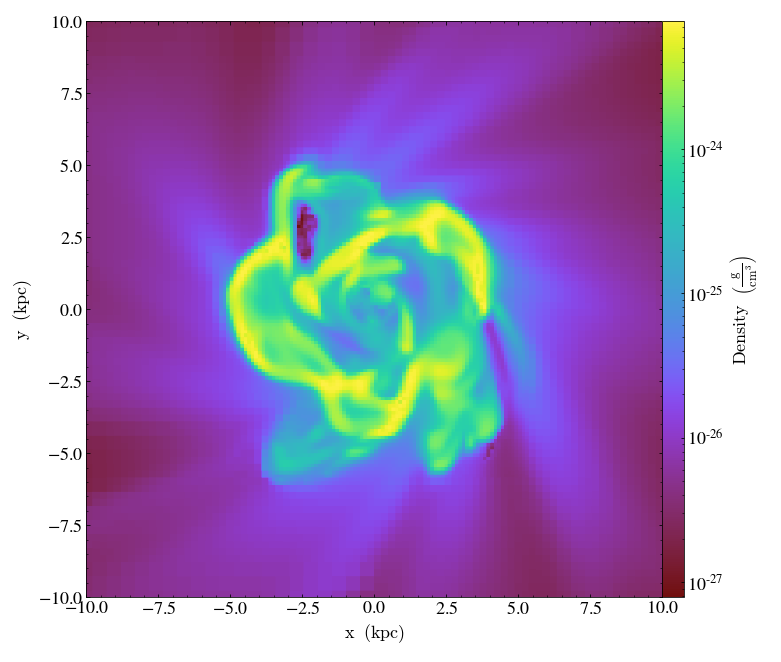

In [4]:
slc = yt.SlicePlot(ds, 'z', 'density', center=[0.5, 0.5, 0.5],width=(20,'kpc'))
slc.show()

## Loading in-memory *yt* Fixed Resolution Region into napari

In order to load *yt* images into napari, we need to be able to create a numpy array to pass to napari. Perhaps the simplest way is to extract a [Fixed Resolution Region](https://yt-project.org/doc/analyzing/objects.html#selecting-fixed-resolution-regions). 

To extract the log of the density over the whole domain at a resolution of 300x300x300 pixels: 

In [5]:
cg = ds.r[::300j,::300j,::300j]
dens_log = np.log10(cg['density'])
print(dens_log.shape)
print(type(dens_log))

(300, 300, 300)
<class 'numpy.ndarray'>


`dens_log` here is an in-memory numpy array that we can simply load into napari. To do so, we first launch a napari viewer and then add `dens_log` as an image layer:

In [6]:
viewer = napari.Viewer()

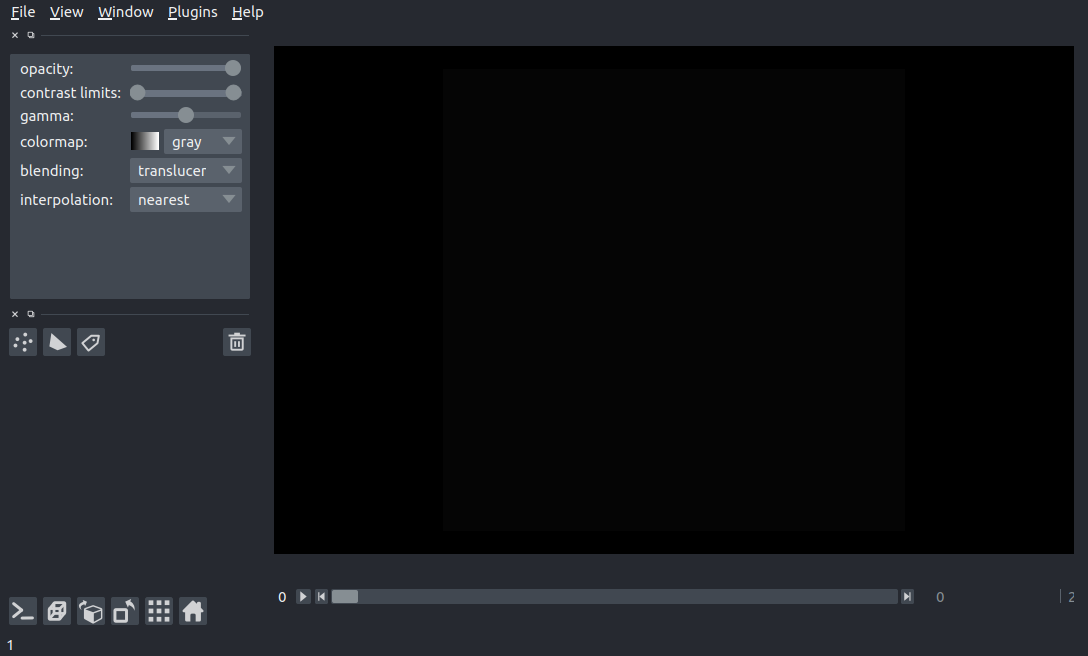

In [7]:
viewer.add_image(dens_log)
nbscreenshot(viewer)

Moving the slider will vary the first dimension of the array that we're slicing along, we can also use napari's color map selector and 3d rendering:

<video controls src="resources/napari_1.mp4" />


### Assembling a 3D array from 2D slices

We can also assemble a 3D array to visualize by concatenating 2D slices. The main reason to take this approach is that it is easily extendible to a dask lazy-loading process, which we'll explore later on. So that we have a more interesting view, we'll pull out a higher resolution focused on the dataset's center.

Let's start by creating a function to slice the data set at a given `x` location and return an image array:

In [8]:
# yt.funcs.mylog.setLevel(50)
c = 500. # center of slices in kpc
hwid = 25. # half width of region to slice in kpc 
res = 300
def return_frame_slice(xval):    
    # return a slice at a single xvalue: 
    region = ds.r[(xval,'kpc'), (c-hwid,'kpc'):(c+hwid,'kpc'):res*1j,
              (c-hwid,'kpc'):(c+hwid,'kpc'):res*1j]
    return np.log10(region['density'])

and define the range we want to slice over:

In [9]:
xvals = np.linspace(c-hwid,c+hwid,res)

before assembling the array, we'll turn off the yt logging so we're not overwhelmed by output:

In [10]:
yt.funcs.mylog.setLevel(50)

Now we'll assemble the array (this is what we'll "daskify" in a later notebook):

In [11]:
%%time
dens_log_2 = np.array([return_frame_slice(xval) for xval in xvals])
dens_log_2.shape

CPU times: user 16.7 s, sys: 1.02 s, total: 17.8 s
Wall time: 17.8 s


(300, 300, 300)

and add it to the viewer:

In [12]:
viewer.add_image(dens_log_2)

<Image layer 'dens_log_2' at 0x7f2eb0668850>

<video controls src="resources/napari_2.mp4" />

## Lazy-loading with Dask

The most obvious way to leverage dask in this process is to transform the image frame loop into a stack of lazy dask processes, so that napari generates each frame as it's selected, following Lambert's [napari-dask-example notebook](https://github.com/tlambert03/napari-dask-example/blob/master/dask_napari.ipynb).

We'll be using `dask.delayed` and `dask.array as da` here and we'll start by creating a function to process each frame. While we could wrap the previous `return_frame_slice`, we'll write a new one to slice along the `z` dimensions:

In [13]:
res = 2000
hwid = 500
zvals = np.linspace(c-hwid,c+hwid,res)

def return_frame_slice_z(zval):    
    # return a slice at a single zvalue: 
    region = ds.r[(c-hwid,'kpc'):(c+hwid,'kpc'):res*1j,
              (c-hwid,'kpc'):(c+hwid,'kpc'):res*1j, (zval,'kpc')]
    return np.log10(region['density'])

Now we pull out a sample frame and build our lazy "reader" by giving it our `return_frame` function:

In [14]:
sample = return_frame_slice_z(zvals[0])
lazy_frame = delayed(return_frame_slice_z)  # our lazy "reader"

Now we need to build up our lazy loaded arrays into an image stack: 

In [15]:
lazy_arrays = [lazy_frame(zval) for zval in zvals]
dask_arrays = [
    da.from_delayed(lazy_array, shape=sample.shape, dtype=sample.dtype)
    for lazy_array in lazy_arrays
]

From which we build up a single dask array stack:

In [16]:
dask_stack = da.stack(dask_arrays, axis=0)
dask_stack

,Array,Chunk
Bytes,64.00 GB,32.00 MB
Shape,"(2000, 2000, 2000)","(1, 2000, 2000)"
Count,6000 Tasks,2000 Chunks
Type,float64,numpy.ndarray


As we can see, if we were to load this all into memory, we'd need 64 Gb of memory, but each slice will be 32 Mb. So let's load it into napari (after closing any existing viewer if it's still open):

In [17]:
np.seterr(divide='ignore')
try: 
    viewer.close()
except:
    pass
viewer = napari.Viewer()
viewer.add_image(dask_stack)

<Image layer 'dask_stack' at 0x7f2e84b95ed0>

Now when we move the slider, napari will traverse the `z` slices, loading them as needed:

<video controls src="resources/napari_3.mp4" />